In [3]:
# importing the requests library 
import requests 
import pandas as pd
from random import sample 
import matplotlib
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys
import scipy
import matplotlib as mpl
import math

### General Notes
How to handle Orientation of genes?

In [4]:
df_genes = pd.read_csv("all_phage_genes.csv")
df_genes = df_genes.applymap(str)
df_genes["GeneNumber"] = df_genes["GeneNumber"].apply(pd.to_numeric)
df_genes.head()

,GeneID,HostStrain,Cluster,Pham,Function,Translation,Orientation,PhageName,GeneNumber
0,20ES_CDS_1,Mycobacterium,A2,36676,nan,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1
1,20ES_CDS_10,Mycobacterium,A2,34452,lysin B,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10
2,20ES_CDS_11,Mycobacterium,A2,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11
3,20ES_CDS_12,Mycobacterium,A2,37970,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12
4,20ES_CDS_13,Mycobacterium,A2,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13


In [5]:
df_genes.describe(include = 'all')

,GeneID,HostStrain,Cluster,Pham,Function,Translation,Orientation,PhageName,GeneNumber
count,348351,348351,348351,348351,348351,348351,348351,348351,348351.000000
unique,348351,14,274,23208,1788,155628,2,3510,NaN
top,Mule_CDS_53,Mycobacterium,C1,34452,nan,MTDQTHEAPPVPRYLSRDEVAKRLGMKSVRSLSGIELPPPDVEVGK...,F,PauloDiaboli,NaN
freq,1,215767,33229,1055,244309,211,247473,352,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.994104
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.243075
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.000000


### Generate Graph (nodes: function, edges: directed adjcency 5'->3 between nodes' )
##### W/ edge attribute p where p is the observed probability of moving from node i to node j

In [6]:
phages = sorted(list(df_genes[df_genes["Cluster"]=="A1"]["PhageName"].unique()))
gene_identifier = "Function"
G = nx.Graph()
G.add_node("start", clusters=[], freq = 0)
G.add_node("end", clusters=[], freq = 0)

for phage in phages:
    phage_df = df_genes[df_genes["PhageName"]==phage].sort_values(by=['GeneNumber'])
    prev_identifier = "start"
    G.nodes[prev_identifier]["freq"] += 1
    for index, row in phage_df.iterrows():
        identifier = row[gene_identifier]
        if not G.has_node(identifier):
            G.add_node(identifier, clusters=[row["Cluster"]], freq = 1)
        else:
            G.nodes[identifier]["freq"] += 1
            G.nodes[identifier]["clusters"].append(row["Cluster"])
            
        if G.has_edge(prev_identifier, identifier):
            G.edges[prev_identifier, identifier]["weight"] += 1  
        else:
            G.add_edge(prev_identifier, identifier, weight = 1)
            
        prev_identifier = identifier


#### Calculate probabilites 

In [7]:
for u,v in G.edges():
    G.edges[u,v]["probability"] = G.edges[u,v]["weight"]/G.nodes[u]["freq"]

In [8]:
nx.adjacency_matrix(G, weight = "probabilty")

<211x211 sparse matrix of type '<class 'numpy.int64'>'
	with 912 stored elements in Compressed Sparse Row format>

#### Draw Grap A1 subcluster

TypeError: 'LineCollection' object is not iterable

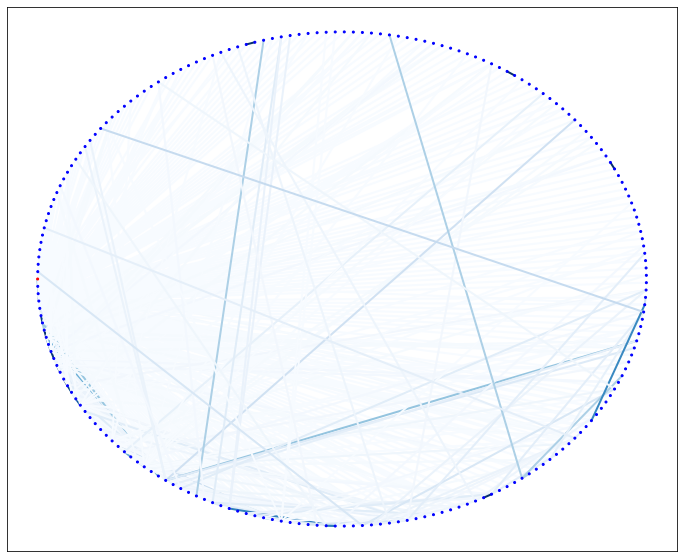

In [9]:
#https://networkx.github.io/documentation/latest/auto_examples/drawing/plot_directed.html#sphx-glr-auto-examples-drawing-plot-directed-py
fig, ax = plt.subplots(figsize=(12,10))

# pos = nx.layout.spring_layout(G, weight="probability")
pos = nx.layout.shell_layout(G)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = [math.floor(G.edges[u,v]["probability"]*100) for u, v in G.edges()]
node_colors = ["blue" if n!= "start" else "red" for n in G.nodes()]
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
node_sizes = 4
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes ,node_color=node_colors)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=plt.cm.Blues,
    width=2,
)
# set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()